## Model Data:

### Reduced Categories

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import plotly.express as px
# plt.style.use('bmh')
import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=[SettingWithCopyWarning, FutureWarning])

import jenkspy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn import linear_model

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import power_transform

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

## IMPORT DATA

In [124]:
# import executive compensation data
df = pd.read_csv('02.data/executive_comp_data.csv')

# import governance data
# comp = pd.read_csv('02.data/xxx.csv')

In [21]:
df.shape

(40097, 20)

In [22]:
df.head()

,ein,period,title,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,subsection,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
0,10877614,201712,BOARD MEMBER/MANAGING D,True,NaN,NaN,NaN,NaN,55385.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
1,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,60000.0,HEART CHANGE MINISTRIES INC,501(c)(3),G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
2,10884383,201712,PRESIDENT,True,NaN,True,NaN,NaN,71062.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
3,10884383,201712,VICE PRESIDENT,True,NaN,True,NaN,NaN,9010.0,MILAGRE KIDS SCHOOLS INC,501(c)(3),B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
4,10906593,201712,VP OF FINANC,True,NaN,True,NaN,NaN,87452.0,MANAGEMENT SERVICES INC,501(c)(3),S02,Management and technical assistance - Communit...,CA,2008.0,4161179,120847.0,881055.0,795668.0,S


(21.5, -0.5)

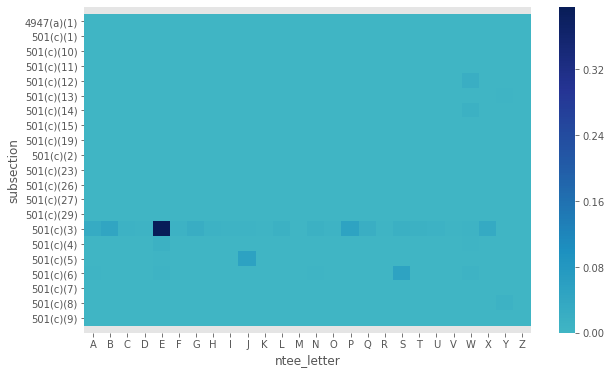

In [147]:
# compare features using a heatmap
plt.figure(figsize=(10, 6))

ax = sns.heatmap(pd.crosstab(df.subsection, df.ntee_letter, values=df.reportable_comp, aggfunc='sum', normalize=True), 
                 center=0, 
                 square=False, annot=False, 
                 cmap="YlGnBu")
# "RdBu"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [125]:
(df.groupby(['subsection', 'ntee_letter'])['reportable_comp'].sum().sort_values(ascending=False)/ \
df.groupby(['subsection', 'ntee_letter'])['reportable_comp'].sum().sum() * 100).head(50)

subsection  ntee_letter
501(c)(3)   E              39.624607
501(c)(5)   J               5.510279
501(c)(3)   P               5.142796
501(c)(6)   S               5.082191
501(c)(3)   B               4.636572
            X               3.151932
            A               3.080607
            G               2.250875
            Q               2.032120
501(c)(12)  W               1.958996
501(c)(3)   S               1.674970
            T               1.520956
            L               1.407499
501(c)(14)  W               1.260582
501(c)(4)   E               1.250674
501(c)(3)   N               1.248276
            F               1.190308
            H               1.023957
            U               1.016251
            C               0.984637
501(c)(8)   Y               0.939997
501(c)(3)   W               0.926801
501(c)(6)   E               0.895477
501(c)(3)   O               0.860473
501(c)(6)   W               0.858084
501(c)(3)   J               0.762933
            D 

In [47]:
subsection_ntee_combination = (df.groupby(['subsection', 'ntee_letter'])['reportable_comp'].sum().sort_values(ascending=False)/ \
df.groupby(['subsection', 'ntee_letter'])['reportable_comp'].sum().sum() * 100).head(50)

In [56]:
# what percent of total does this make up?
subsection_ntee_combination[subsection_ntee_combination > .5].sum()

92.90745455677883

In [79]:
# subsections and ntee codes that make up at least .5% of total
(subsection_ntee_combination[subsection_ntee_combination > .5].reset_index().iloc[:, 0] + ' - ' +\
subsection_ntee_combination[subsection_ntee_combination > .5].reset_index().iloc[:, 1]).values

array(['501(c)(3) - E', '501(c)(5) - J', '501(c)(3) - P', '501(c)(6) - S',
       '501(c)(3) - B', '501(c)(3) - X', '501(c)(3) - A', '501(c)(3) - G',
       '501(c)(3) - Q', '501(c)(12) - W', '501(c)(3) - S',
       '501(c)(3) - T', '501(c)(3) - L', '501(c)(14) - W',
       '501(c)(4) - E', '501(c)(3) - N', '501(c)(3) - F', '501(c)(3) - H',
       '501(c)(3) - U', '501(c)(3) - C', '501(c)(8) - Y', '501(c)(3) - W',
       '501(c)(6) - E', '501(c)(3) - O', '501(c)(6) - W', '501(c)(3) - J',
       '501(c)(3) - D', '501(c)(3) - I', '501(c)(6) - A', '501(c)(6) - N'],
      dtype=object)

### Consolidate Subsections

In [15]:
df.subsection.value_counts()

501(c)(3)     21301
501(c)(5)      6735
501(c)(12)     3970
501(c)(6)      2872
501(c)(4)      1851
501(c)(14)      822
501(c)(8)       624
501(c)(9)       464
501(c)(10)      463
501(c)(13)      418
501(c)(7)       283
501(c)(19)      126
501(c)(15)       67
501(c)(2)        42
501(c)(29)       31
501(c)(27)       19
501(c)(11)        3
501(c)(23)        2
4947(a)(1)        2
501(c)(26)        1
501(c)(1)         1
Name: subsection, dtype: int64

In [75]:
df.subsection + ' - ' + df.ntee_letter

0        501(c)(3) - G
1        501(c)(3) - G
2        501(c)(3) - B
3        501(c)(3) - B
4        501(c)(3) - S
             ...      
40092    501(c)(5) - J
40093    501(c)(3) - A
40094    501(c)(3) - P
40095    501(c)(3) - P
40096    501(c)(6) - E
Length: 40097, dtype: object

In [134]:
df['sub_ntee_comb'] = df.subsection + ' - ' + df.ntee_letter

In [77]:
df.subsection

0        501(c)(3)
1        501(c)(3)
2        501(c)(3)
3        501(c)(3)
4        501(c)(3)
           ...    
40092    501(c)(5)
40093    501(c)(3)
40094    501(c)(3)
40095    501(c)(3)
40096    501(c)(6)
Name: subsection, Length: 40097, dtype: object

In [135]:
df.loc[~ df.sub_ntee_comb.isin((subsection_ntee_combination[subsection_ntee_combination > .5].reset_index().iloc[:, 0] + ' - ' +\
subsection_ntee_combination[subsection_ntee_combination > .5].reset_index().iloc[:, 1]).values), 'sub_ntee_comb'] = 'Other'

In [136]:
df.sub_ntee_comb.value_counts()

Other             6965
501(c)(5) - J     5132
501(c)(3) - E     4573
501(c)(12) - W    3868
501(c)(3) - P     2336
501(c)(3) - B     2044
501(c)(3) - X     1797
501(c)(3) - A     1658
501(c)(6) - S     1266
501(c)(3) - N     1108
501(c)(14) - W     801
501(c)(3) - Q      728
501(c)(3) - S      725
501(c)(3) - G      686
501(c)(3) - L      624
501(c)(4) - E      624
501(c)(3) - T      612
501(c)(8) - Y      538
501(c)(3) - F      532
501(c)(3) - C      453
501(c)(3) - D      452
501(c)(3) - O      397
501(c)(3) - W      382
501(c)(6) - E      363
501(c)(3) - I      318
501(c)(3) - J      309
501(c)(3) - H      246
501(c)(3) - U      237
501(c)(6) - W      121
501(c)(6) - N      115
501(c)(6) - A       87
Name: sub_ntee_comb, dtype: int64

In [91]:
df.drop(['subsection'], axis=1, inplace=True)

In [92]:
df.head()

,ein,period,title,trustee_or_director,institutional_trustee,officer,key_employee,highest_compensated,reportable_comp,org_name,ntee_code,ntee_description,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter,sub_ntee_comb
0,10877614,201712,BOARD MEMBER/MANAGING D,True,NaN,NaN,NaN,NaN,55385.0,HEART CHANGE MINISTRIES INC,G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G,501(c)(3) - G
1,10877614,201712,BOARD MEMBER,True,NaN,NaN,NaN,NaN,60000.0,HEART CHANGE MINISTRIES INC,G43,"Heart and Circulatory System Diseases, Disorders",IN,2006.0,2112293,92283.0,500749.0,1792933.0,G,501(c)(3) - G
2,10884383,201712,PRESIDENT,True,NaN,True,NaN,NaN,71062.0,MILAGRE KIDS SCHOOLS INC,B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B,501(c)(3) - B
3,10884383,201712,VICE PRESIDENT,True,NaN,True,NaN,NaN,9010.0,MILAGRE KIDS SCHOOLS INC,B28,Specialized Education Institutions,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B,501(c)(3) - B
4,10906593,201712,VP OF FINANC,True,NaN,True,NaN,NaN,87452.0,MANAGEMENT SERVICES INC,S02,Management and technical assistance - Communit...,CA,2008.0,4161179,120847.0,881055.0,795668.0,S,501(c)(3) - S


In [95]:
df[['sub_ntee_comb',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue',
      'ntee_letter']]

,sub_ntee_comb,state,formation_yr,assets,liabilities,expenses,revenue,ntee_letter
0,501(c)(3) - G,IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
1,501(c)(3) - G,IN,2006.0,2112293,92283.0,500749.0,1792933.0,G
2,501(c)(3) - B,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
3,501(c)(3) - B,PA,2007.0,97123,13093.0,1251188.0,1294636.0,B
4,501(c)(3) - S,CA,2008.0,4161179,120847.0,881055.0,795668.0,S
...,...,...,...,...,...,...,...,...
40092,501(c)(5) - J,HI,1978.0,2754244,28296.0,359991.0,554329.0,J
40093,501(c)(3) - A,HI,1984.0,3187428,2977061.0,4465050.0,3679726.0,A
40094,501(c)(3) - P,HI,1981.0,327992,9503.0,473584.0,475958.0,P
40095,501(c)(3) - P,HI,1981.0,327992,9503.0,473584.0,475958.0,P


In [99]:
pd.get_dummies(df[['sub_ntee_comb',
     'state',
      'formation_yr',
      'assets',
      'liabilities',
      'expenses',
      'revenue']])

,formation_yr,assets,liabilities,expenses,revenue,sub_ntee_comb_501(c)(12) - W,sub_ntee_comb_501(c)(14) - W,sub_ntee_comb_501(c)(3) - A,sub_ntee_comb_501(c)(3) - B,sub_ntee_comb_501(c)(3) - C,sub_ntee_comb_501(c)(3) - D,sub_ntee_comb_501(c)(3) - E,sub_ntee_comb_501(c)(3) - F,sub_ntee_comb_501(c)(3) - G,sub_ntee_comb_501(c)(3) - H,sub_ntee_comb_501(c)(3) - I,sub_ntee_comb_501(c)(3) - J,sub_ntee_comb_501(c)(3) - L,sub_ntee_comb_501(c)(3) - N,sub_ntee_comb_501(c)(3) - O,sub_ntee_comb_501(c)(3) - P,sub_ntee_comb_501(c)(3) - Q,sub_ntee_comb_501(c)(3) - S,sub_ntee_comb_501(c)(3) - T,sub_ntee_comb_501(c)(3) - U,sub_ntee_comb_501(c)(3) - W,sub_ntee_comb_501(c)(3) - X,sub_ntee_comb_501(c)(4) - E,sub_ntee_comb_501(c)(5) - J,sub_ntee_comb_501(c)(6) - A,sub_ntee_comb_501(c)(6) - E,sub_ntee_comb_501(c)(6) - N,sub_ntee_comb_501(c)(6) - S,sub_ntee_comb_501(c)(6) - W,sub_ntee_comb_501(c)(8) - Y,sub_ntee_comb_Other,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY
0,2006.0,2112293,92283.0,500749.0,1792933.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2006.0,2112293,92283.0,500749.0,1792933.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007.0,97123,13093.0,1251188.0,1294636.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2007.0,97123,13093.0,1251188.0,1294636.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2008.0,4161179,120847.0,881055.0,795668.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40092,1978.0,2754244,28296.0,359991.0,554329.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40093,1984.0,3187428,2977061.0,4465050.0,3679726.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40094,1981.0,327992,9503.0,473584.0,475958.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40095,1981.0,327992,9503.0,473584.0,475958.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
